# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **_Your Name_** | _Your Email_ | **_Project Name_** |

# II. Notebook Target Definition

_Insert Text Here_

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, StratifiedKFold
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## III.B. Import Data

In [2]:
X_train = pd.read_pickle('../../data/processed/X_train.pkl')
X_test = pd.read_pickle('../../data/processed/X_test.pkl')
y_train = pd.read_pickle('../../data/processed/y_train.pkl')
y_test = pd.read_pickle('../../data/processed/y_test.pkl')

In [3]:
X_train.head()

,review
670,When i watch this movie i too get excited when...
36224,I just finished watching this (last weekend) a...
39381,Poor second-string feature from Universal Pict...
4397,"When I was younger, this movie always aired on..."
48699,"Don't get me wrong , I want to see marijuana l..."


In [4]:
X_test.head()

,review
21560,A hilarious Action comedy in which Damian Szif...
4334,"This movie has it all. Sight gags, subtle joke..."
42642,This movie is simply awesome. It is so hilario...
31502,Rosario Dawson stars as a girl who is date rap...
49051,PAGE 3 **** out of 4 StarsMadhvi (Konkona Sen)...


In [5]:
y_train.head()

670      1
36224    1
39381    0
4397     1
48699    0
Name: sentiment, dtype: int64

In [6]:
y_test.head()

21560    1
4334     1
42642    1
31502    0
49051    1
Name: sentiment, dtype: int64

# IV. Models Training and Evaluation

## IV.A. Data Shape Inspection

In [7]:
X_train.shape, X_test.shape

((39665, 1), (9917, 1))

In [8]:
y_train.shape, y_test.shape

((39665,), (9917,))

## IV.B. Data Information Inspection

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39665 entries, 670 to 12021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  39665 non-null  object
dtypes: object(1)
memory usage: 619.8+ KB


In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9917 entries, 21560 to 13348
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9917 non-null   object
dtypes: object(1)
memory usage: 155.0+ KB


In [11]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 39665 entries, 670 to 12021
Series name: sentiment
Non-Null Count  Dtype
--------------  -----
39665 non-null  int64
dtypes: int64(1)
memory usage: 619.8 KB


In [12]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 9917 entries, 21560 to 13348
Series name: sentiment
Non-Null Count  Dtype
--------------  -----
9917 non-null   int64
dtypes: int64(1)
memory usage: 155.0 KB


## IV.C. Tokens Preprocessing

In [13]:
max_vocab_size = 30000
max_length = 300
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train["review"])
X_train_seq = tokenizer.texts_to_sequences(X_train["review"])
X_test_seq = tokenizer.texts_to_sequences(X_test["review"])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [14]:
model = Sequential([
    Embedding(max_vocab_size, 128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

## IV.D. Baseline Model Training

In [15]:
history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/10


1240/1240 [==============================] - 90s 71ms/step - loss: 0.6472 - accuracy: 0.5841 - val_loss: 0.6618 - val_accuracy: 0.5531
Epoch 2/10
1240/1240 [==============================] - 87s 70ms/step - loss: 0.5394 - accuracy: 0.7312 - val_loss: 0.5518 - val_accuracy: 0.7266
Epoch 3/10
1240/1240 [==============================] - 87s 70ms/step - loss: 0.5391 - accuracy: 0.7317 - val_loss: 0.4814 - val_accuracy: 0.8056
Epoch 4/10
1240/1240 [==============================] - 86s 69ms/step - loss: 0.4556 - accuracy: 0.8001 - val_loss: 0.4818 - val_accuracy: 0.8109
Epoch 5/10
1240/1240 [==============================] - 87s 70ms/step - loss: 0.4646 - accuracy: 0.7951 - val_loss: 0.5117 - val_accuracy: 0.7920
Epoch 6/10
1240/1240 [==============================] - 88s 71ms/step - loss: 0.4077 - accuracy: 0.8332 - val_loss: 0.4945 - val_accuracy: 0.7867


## IV.E. Baseline Model Performance Review

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

def get_metrics_dataframe(model, X_train, y_train, X_test, y_test):
    # For Keras, .predict_classes() is used for classification tasks
    train_prediction = (model.predict(X_train) > 0.5).astype("int32")
    test_prediction = (model.predict(X_test) > 0.5).astype("int32")

    # For Keras, .predict() gives the predicted probabilities
    train_probs = model.predict(X_train)
    test_probs = model.predict(X_test)

    def get_prediction_metrics(y_true, y_pred, y_probs):
        report = classification_report(y_true, y_pred, output_dict=True)
        accuracy = accuracy_score(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_probs)
        gini = 2 * auc_roc - 1
        metrics = {
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1-score": report["weighted avg"]["f1-score"],
            "accuracy": accuracy,
            "auc_roc": auc_roc,
            "gini": gini
        }
        return metrics

    train_metrics = get_prediction_metrics(y_train, train_prediction, train_probs)
    train_metrics["dataset"] = "Train"
    test_metrics = get_prediction_metrics(y_test, test_prediction, test_probs)
    test_metrics["dataset"] = "Test"
    return pd.DataFrame([train_metrics, test_metrics])

def display_confusion_matrix(model, X_train, y_train, X_test, y_test):
    train_prediction = (model.predict(X_train) > 0.5).astype("int32")
    test_prediction = (model.predict(X_test) > 0.5).astype("int32")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ConfusionMatrixDisplay.from_predictions(y_train, train_prediction, ax=ax[0])
    ax[0].set_title("Train Confusion Matrix")
    ConfusionMatrixDisplay.from_predictions(y_test, test_prediction, ax=ax[1])
    ax[1].set_title("Test Confusion Matrix")
    plt.show()

def plot_train_vs_test_error(model, X_train, y_train, X_test, y_test):
    y_pred_train = (model.predict(X_train) > 0.5).astype("int32")
    y_pred_test = (model.predict(X_test) > 0.5).astype("int32")
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    bars = plt.bar(["Train Error", "Test Error"], [train_error, test_error])
    plt.ylabel("Error Rate")
    plt.title("Train vs Test Error")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, round(yval, 2), ha='center', va='bottom')
    plt.show()

def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    y_pred_train_prob = model.predict(X_train)
    y_pred_test_prob = model.predict(X_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_prob)
    plt.figure(figsize=(12, 6))
    plt.plot(fpr_train, tpr_train, label=f"Train AUC: {roc_auc_score(y_train, y_pred_train_prob):.2f}")
    plt.plot(fpr_test, tpr_test, label=f"Test AUC: {roc_auc_score(y_test, y_pred_test_prob):.2f}")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc='best')
    plt.show()

In [18]:
metrics_df = get_metrics_dataframe(model, X_train_pad, y_train, X_test_pad, y_test)
metrics_df

310/310 [==============================] - 7s 23ms/step


,precision,recall,f1-score,accuracy,auc_roc,gini,dataset
0,0.846389,0.840867,0.840184,0.840867,0.920071,0.840142,Train
1,0.793165,0.786730,0.785472,0.786730,0.851305,0.702609,Test


310/310 [==============================] - 7s 23ms/step


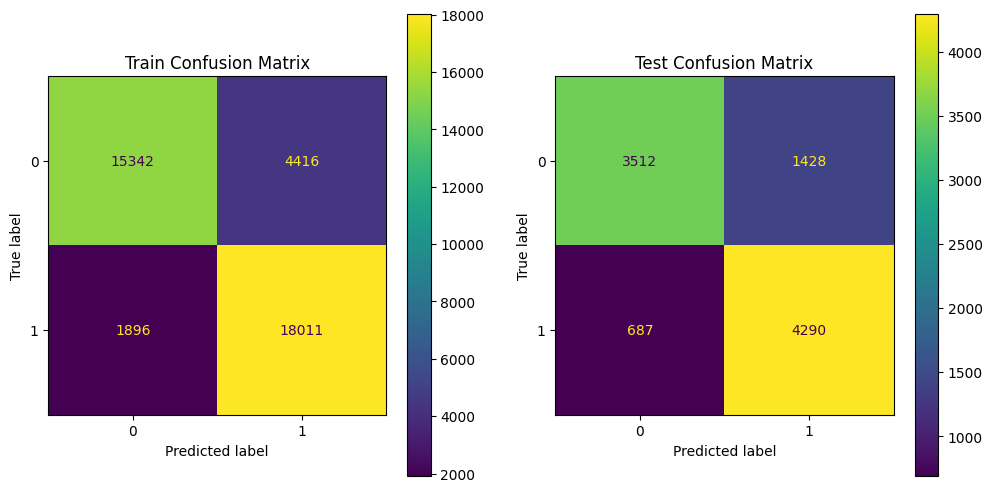

In [19]:
display_confusion_matrix(model, X_train_pad, y_train, X_test_pad, y_test)

310/310 [==============================] - 7s 24ms/step


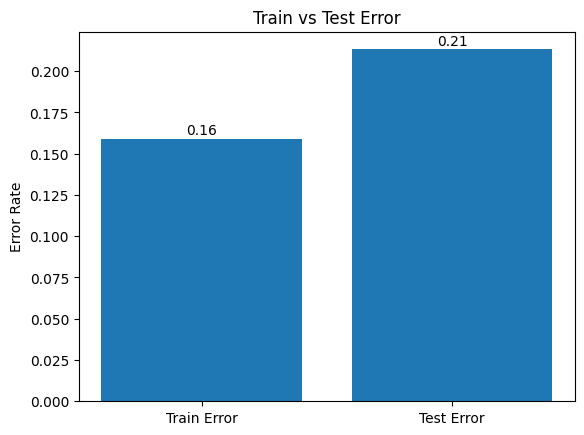

In [20]:
plot_train_vs_test_error(model, X_train_pad, y_train, X_test_pad, y_test)

310/310 [==============================] - 7s 23ms/step


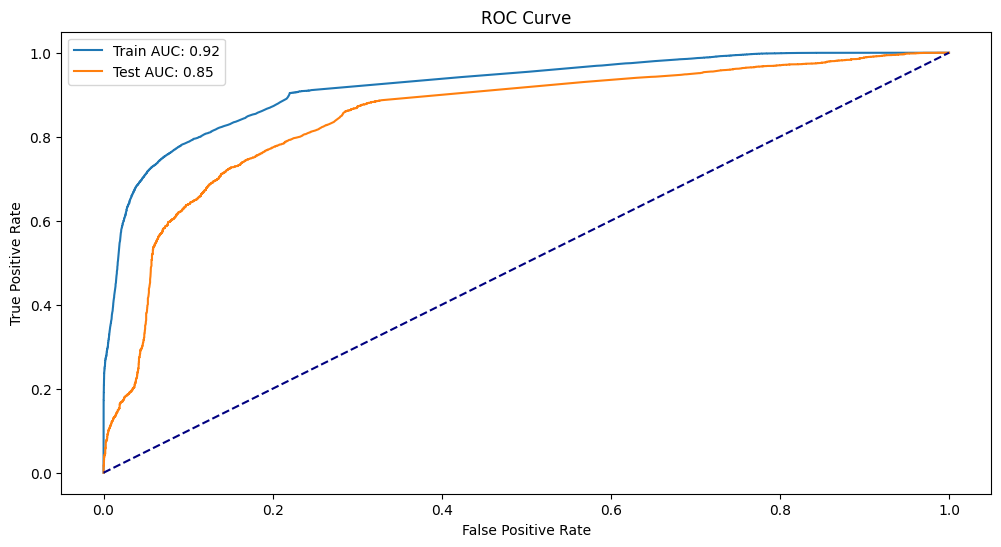

In [21]:
plot_roc_curve(model, X_train_pad, y_train, X_test_pad, y_test)

## IV.F. Hyperparameters Tuning

In [ ]:
from kerastuner import HyperModel
from keras.layers import Dropout

class LSTMHyperModel(HyperModel):
    def __init__(self, max_vocab_size, max_length):
        self.max_vocab_size = max_vocab_size
        self.max_length = max_length

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(self.max_vocab_size, hp.Int('embedding_dim', 32, 128, step=32), input_length=self.max_length))
        model.add(LSTM(hp.Int('lstm_units', 32, 128, step=32)))
        model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

from kerastuner.tuners import RandomSearch

hypermodel = LSTMHyperModel(max_vocab_size=max_vocab_size, max_length=max_length)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hparam_tuning'
)

tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test))

best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

In [ ]:
# Predict OOT Data

# Example new data (replace this with your actual test data)
new_reviews = ["This movie was excellent! The performances were oscar-worthy!",
               "I did not like this movie, it was too long and boring."]

# Preprocess the new data
new_reviews_seq = tokenizer.texts_to_sequences(new_reviews)
new_reviews_pad = pad_sequences(new_reviews_seq, maxlen=max_length, padding='post')

# Make predictions
predictions = model.predict(new_reviews_pad)

# Since the output is a probability (due to the sigmoid activation), 
# you might want to convert it to a binary outcome based on a threshold
predicted_classes = [1 if prob > 0.5 else 0 for prob in predictions]

# Print predictions
for review, prediction in zip(new_reviews, predicted_classes):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {'Positive' if prediction == 1 else 'Negative'}\n")


### IV.F.2. Best Model Hyperparameter Retraining

### IV.F.3. Hyperparameter-tuned Model Performance Review

In [ ]:
all_training_logs_df_tuned = training_log_to_df_converter(training_log)
all_training_logs_df_tuned

### IV.F.4. Export Hyperparameter-tuned Best Model

In [ ]:
with open('../../models/tuned_best_model.pkl', 'wb') as file:
    pickle.dump(tuned_best_model, file)